In [421]:
import re 
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from analytics_utils.bigquery_utils import get_bq_client, BigQuery
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
STAGE_MAP = {
    'New': 1, 'Review': 2, 'Marked Relevant': 4, 
    'Opened': 2, 'Clicked': 2, 'Delivered': 4, 
    'Suppressed': 3, 'Dismissed': 3
}

REVERSE_STAGE_MAP = {
    1: 'New',
    2: 'Review',
    3: 'Dismissed',
    4: 'Marked Relevant'
}

DIM_MAP = {
    'Client': "fetch_recommendation_activity_customer", 
    'Client Industry': "Industry", 
    'Req Seniority': "dim_req_required_seniority_level", 
    'Req Top Category': "dim_req_top_category_calculated"
}

PATTERN_DELETE = r'(?=.+posit.+fill.+)|(?=.+posit.+interna.+)|(?=.+terna.+nly.+)|(?=.+interna.+fill.+)|(?=.+cand.+not.+interested.+)|(?=.+not.+reach.+)|(?=.+reach.+not.+)|(?=.+urrent.+employ.+)|(?=.*\bprocess\b.*\banother\b.*\breq\b)'

REASONS_TO_FILTER = {
    'other: Position will be filled internally ',
    'Candidate invited to apply',
    'In process in another req ',
    'Current Employee',
    'other: Position filled',
    'other: Internal only',
    'Qualified but candidate not interested at this time',
    
}

REASONS_TO_FILTER = {x.lower().strip() for x in REASONS_TO_FILTER}

def check_id(user_id):
    if user_id:
        if 'test' in user_id:
            return False
        elif str(user_id).endswith('-1'):
            return False
    return True

client_industry = pd.read_excel('planhat-companies-Oct-29-2023.xlsx')

In [36]:
def get_dataframe(from_date, to_date, account):
    db_client = get_bq_client('production')
    sql = f"""
        SELECT
            fact_recommendation_status_history.analytics_fetch_status_bucket  AS fact_recommendation_status_history_fetch_bucket,
            fetch_recommendation_activity.req_id  AS fetch_recommendation_activity_req_id,
            fetch_recommendation_activity.talent_id  AS fetch_recommendation_activity_talent_id,
            fact_recommendation_status_history.reason  AS fact_recommendation_status_history_reason,
            (DATE(fact_recommendation_status_history.status_ts )) AS fact_recommendation_status_history_status_at_date,
            fetch_recommendation_activity.customer  AS fetch_recommendation_activity_customer,
            dim_req.required_seniority_level  AS dim_req_required_seniority_level,
            dim_req.top_category  AS dim_req_top_category_calculated,
            fact_recommendation_status_history.user_id  AS fact_recommendation_status_history_user_id
        FROM `hs-analytics.all_customers.dwh_hs_dim_recommendation`
             AS fetch_recommendation_activity
        LEFT JOIN `hs-analytics.all_customers.dwh_hs_fact_recommendation_status_history`
             AS fact_recommendation_status_history ON fetch_recommendation_activity.key = fact_recommendation_status_history.recommendation_key
            and fetch_recommendation_activity.customer = fact_recommendation_status_history.customer
        FULL OUTER JOIN `hs-analytics.all_customers.dwh_hs_dim_req`
             AS dim_req ON dim_req.key = fetch_recommendation_activity.req_key
            and dim_req.customer = fetch_recommendation_activity.customer
        WHERE (fact_recommendation_status_history.analytics_fetch_status_bucket ) IN ('Dismissed', 'Marked Relevant', 'Review') 
          --  AND fetch_recommendation_activity.customer = "{account}"
            AND ((( fact_recommendation_status_history.status_ts  ) >= (TIMESTAMP("{str(from_date)}")) 
            AND ( fact_recommendation_status_history.status_ts  ) < (TIMESTAMP("{str(to_date)}")))) 
            AND (fetch_recommendation_activity.customer not in ( 'princeton',
                 'arizona_wd_staging',
                 'antigua',
                 'havana',
                 'seoul_icims',
                 'arizona' ))
        GROUP BY
            1,
            2,
            3,
            4,
            5,
            6,
            7,
            8,
            9
    """
    job_result = db_client.execute(sql)
    df = job_result['query_reults'].to_dataframe()
    df.to_csv('cache_dump.csv', index=None)
    df['Date'] = pd.to_datetime(df['fact_recommendation_status_history_status_at_date'])
    return df

In [37]:
def prepare_df(df):
    calc_df = df.copy()

    calc_df['Date'] = pd.to_datetime(calc_df['fact_recommendation_status_history_status_at_date'])
    for period in ('M', 'W', '2W'):
        calc_df[f'Period {period}'] = calc_df['Date'].dt.to_period(period)

    calc_df['bucket_code'] = calc_df['fact_recommendation_status_history_fetch_bucket'].map(STAGE_MAP)
    calc_df['pair_id'] = calc_df['fetch_recommendation_activity_req_id'].fillna('nan') + '_' + calc_df['fetch_recommendation_activity_talent_id'].fillna('nan')

    leads_to_filter = set(calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['pair_id'].values)


    calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['bucket_code'] = STAGE_MAP['Marked Relevant']

    calc_df = calc_df[
        (~calc_df['pair_id'].isin(leads_to_filter)) & 
        (calc_df['fact_recommendation_status_history_user_id'].fillna('').apply(check_id))
    ]
    grouped_df = calc_df.groupby(
        ['pair_id'], as_index=False
    ).agg(
        {"bucket_code": "max",
         'fetch_recommendation_activity_req_id': 'first',
         'fetch_recommendation_activity_talent_id': 'first',
         'fetch_recommendation_activity_customer': 'first',
         'fact_recommendation_status_history_user_id': 'first',
         'Date': 'max',
         'Period M': 'max',
         'Period W': 'max',
         'Period 2W': 'max',     
         'dim_req_top_category_calculated': 'first',
         'dim_req_required_seniority_level': 'first',
        })

    grouped_df['Max Status Bucket'] = grouped_df['bucket_code'].map(REVERSE_STAGE_MAP)
    grouped_df = pd.concat([grouped_df, pd.get_dummies(grouped_df['Max Status Bucket'])], axis=1)
    grouped_df = grouped_df.dropna(subset=['Max Status Bucket'])

    client_industry['Account Name'] = client_industry['Account Name'].str.lower()
    grouped_df = pd.merge(grouped_df, client_industry, 
                          left_on='fetch_recommendation_activity_customer', 
                          right_on='Account Name', how='left')
    return grouped_df

In [39]:
raw_df = get_dataframe(date(2023, 6, 1), date(2024, 12, 28), account=ACCOUNT)
raw_df.shape

(499854, 10)

In [41]:
raw_df.columns

Index(['fact_recommendation_status_history_fetch_bucket',
       'fetch_recommendation_activity_req_id',
       'fetch_recommendation_activity_talent_id',
       'fact_recommendation_status_history_reason',
       'fact_recommendation_status_history_status_at_date',
       'fetch_recommendation_activity_customer',
       'dim_req_required_seniority_level', 'dim_req_top_category_calculated',
       'fact_recommendation_status_history_user_id', 'Date'],
      dtype='object')

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_58624/3353077257.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_df[


(37744, 18)

In [694]:
gb = ['after', 'fact_recommendation_status_history_user_id', 'dim_req_top_category_calculated']
#gb = ['after', 'fetch_recommendation_activity_req_id', 'dim_req_top_category_calculated']
#gb = ['after', 'fact_recommendation_status_history_user_id']
#gb = ['after', 'fact_recommendation_status_history_user_id', 'dim_req_top_category_calculated', 'fetch_recommendation_activity_req_id']
days = list(range(0, 7*30, 7))

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_58624/3353077257.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_df[


<Figure size 1300x500 with 0 Axes>

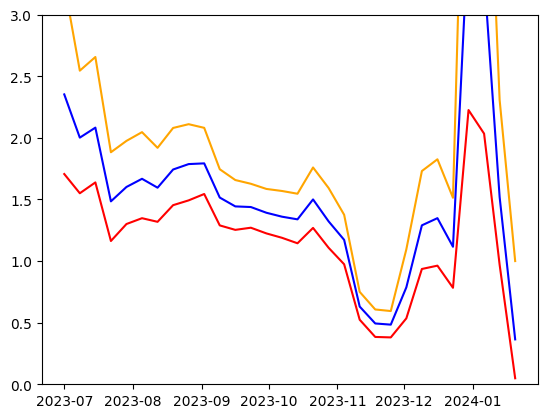

In [729]:
ACCOUNT = 'jamaica'
PERIOD = 90
prep_df = prepare_df(raw_df[raw_df['fetch_recommendation_activity_customer'] == ACCOUNT])
#prep_df = prepare_df(raw_df)
prep_df.shape
ratios = []
dates = []
low = []
high = []
for days_to_add in days:
    curr_date = datetime(2023, 7, 1) + timedelta(days=days_to_add)
    sub_df = prep_df[(prep_df['Date'] > curr_date + timedelta(days=-PERIOD)) &  (prep_df['Date'] < curr_date + timedelta(days=PERIOD))].copy()
    
    sub_df['after'] = sub_df['Date'] > curr_date
    sub_df['after'].mean()
    xdf = sub_df.groupby(gb).sum()[['Marked Relevant', 'Dismissed', 'Review']].reset_index()
    xdf['total'] = xdf['Marked Relevant'] + xdf['Dismissed'] + xdf['Review']
    xdf['rate'] = xdf['Marked Relevant'] / xdf['total']
    
    rates = xdf.set_index(gb)[['rate', 'Marked Relevant', 'Dismissed', 'Review', 'total']].unstack(0).dropna()
    
    rates = rates[(rates[('total', False)] > 10) & (rates[('total', True)] > 10)]
    #ratios.append(rates[('rate', True)].mean() / rates[('rate', False)].mean())
    
    before_rate = rates[('Marked Relevant', False)].sum() / rates[('total', False)].sum()
    after_rate = rates[('Marked Relevant', True)].sum() / rates[('total', True)].sum()
    
    #ratios.append(after_rate/ before_rate)
    dates.append(curr_date)
    
    before_population = ['relevant']*int(rates[('Marked Relevant', False)].sum()) + ['dismissed']*int(rates[('Dismissed', False)].sum()) + ['dismissed']*int(rates[('Review', False)].sum())
    after_population = ['relevant']*int(rates[('Marked Relevant', True)].sum()) + ['dismissed']*int(rates[('Dismissed', True)].sum()) + ['dismissed']*int(rates[('Review', True)].sum())
    bootstrap_rates = []
    for _ in range(1000):
        before_sample = Counter(np.random.choice(before_population, size=len(before_population), replace=True))
        after_sample = Counter(np.random.choice(after_population, size=len(before_population), replace=True))

        bs_before_rate = before_sample['relevant'] / sum(before_sample.values())
        bs_after_rate = after_sample['relevant'] / sum(after_sample.values())
        
        if bs_before_rate == 0:
            bs_before_rate = 0.01
            
        bootstrap_ratio = bs_after_rate / bs_before_rate 
        bootstrap_rates.append(bootstrap_ratio)
    
    confidence_interval = np.percentile(bootstrap_rates, [2.5, 97.5])
    
    low.append(confidence_interval[0])
    high.append(confidence_interval[1])
    ratios.append(np.mean(bootstrap_rates))
    #ratios.append(after_rate/ before_rate)
    
fig = plt.figure(figsize=(13, 5))
fig, ax = plt.subplots()
ax.set_ylim(0, 3) 
plt.plot(dates, low, color='red')
plt.plot(dates, high, color='orange')
plt.plot(dates, ratios, color='blue')

<Figure size 1300x500 with 0 Axes>

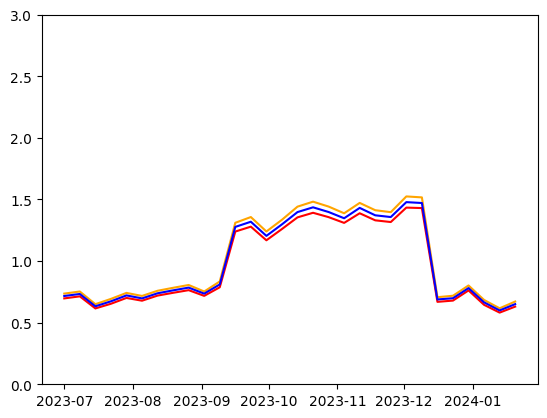

In [728]:
fig = plt.figure(figsize=(13, 5))
fig, ax = plt.subplots()
ax.set_ylim(0, 3) 
plt.plot(dates, low, color='red')
plt.plot(dates, high, color='orange')
plt.plot(dates, ratios, color='blue')

In [689]:
gb = ['after', 'fact_recommendation_status_history_user_id', 'dim_req_top_category_calculated', 'fetch_recommendation_activity_req_id']
#gb = ['after', 'fact_recommendation_status_history_user_id', 'dim_req_top_category_calculated']
#gb = ['after', 'fact_recommendation_status_history_user_id']
#gb = ['x']
curr_date =  datetime(2024, 1,6) 
sub_df = prep_df[(prep_df['Date'] > curr_date + timedelta(days=-PERIOD)) &  (prep_df['Date'] < curr_date + timedelta(days=PERIOD))].copy()

sub_df['after'] = sub_df['Date'] > curr_date
sub_df['after'].mean()
xdf = sub_df.groupby(gb).sum()[['Marked Relevant', 'Dismissed', 'Review']].reset_index()
xdf['total'] = xdf['Marked Relevant'] + xdf['Dismissed'] + xdf['Review']
xdf['rate'] = xdf['Marked Relevant'] / xdf['total']

rates = xdf.set_index(gb)[['rate', 'Marked Relevant', 'Dismissed', 'Review', 'total']].unstack(0)#.dropna()

#rates = rates[(rates[('total', False)] > 10) & (rates[('total', True)] > 10)]
#ratios.append(rates[('rate', True)].mean() / rates[('rate', False)].mean())

before_rate = rates[('Marked Relevant', False)].sum() / rates[('total', False)].sum()
after_rate = rates[('Marked Relevant', True)].sum() / rates[('total', True)].sum()

before_rate, after_rate

(0.42322834645669294, 0.2751322751322751)

In [690]:
rates.xs('JNJ163', level='fact_recommendation_status_history_user_id')

rate  \
after                                                                    False   
dim_req_top_category_calculated fetch_recommendation_activity_req_id             
Engineering                     JNJ2306131285W                        0.600000   
                                JNJ2306152124W                        0.523810   
Manufacturing                   JNJ2306141923W                        0.818182   
                                JNJ2306147924W                        1.000000   
                                JNJ2306149771W                        0.512821   
                                JNJ2306157679W                        0.000000   
                                JNJ2306158675W                        1.000000   
Supply_Chain_Management         JNJ2306144084W                        0.375000   
                                JNJ2306156836W                        0.857143   
                                JNJ2306157570W                        1.000000   
                                JNJ2306158482W                             NaN   
                                JNJ2406159994W                             NaN   
                                JNJ2406163555W                             NaN   

                                                                                \
after                                                                     True   
dim_req_top_category_calculated fetch_recommendation_activity_req_id             
Engineering                     JNJ2306131285W                             NaN   
                                JNJ2306152124W                             NaN   
Manufacturing                   JNJ2306141923W                             NaN   
                                JNJ2306147924W                             NaN   
                                JNJ2306149771W                             NaN   
                                JNJ2306157679W                             NaN   
                                JNJ2306158675W                             NaN   
Supply_Chain_Management         JNJ2306144084W                             NaN   
                                JNJ2306156836W                             NaN   
                                JNJ2306157570W                        1.000000   
                                JNJ2306158482W                        0.857143   
                                JNJ2406159994W                        0.666667   
                                JNJ2406163555W                        1.000000   

                                                                     Marked Relevant  \
after                                                                          False   
dim_req_top_category_calculated fetch_recommendation_activity_req_id                   
Engineering                     JNJ2306131285W                                   3.0   
                                JNJ2306152124W                                  11.0   
Manufacturing                   JNJ2306141923W                                   9.0   
                                JNJ2306147924W                                  14.0   
                                JNJ2306149771W                                  20.0   
                                JNJ2306157679W                                   0.0   
                                JNJ2306158675W                                   8.0   
Supply_Chain_Management         JNJ2306144084W                                   3.0   
                                JNJ2306156836W                                   6.0   
                                JNJ2306157570W                                   1.0   
                                JNJ2306158482W                                   NaN   
                                JNJ2406159994W                                   NaN   
                                JNJ2406163555W                                   NaN   

                                       

In [685]:
rates

rate  \
after                                                                          False   
fact_recommendation_status_history_user_id dim_req_top_category_calculated             
JNJ1080                                    Medical                          0.000000   
                                           Sales                            0.000000   
JNJ1200                                    Medical                          0.175000   
                                           Sales                            0.181818   
JNJ1517                                    Sales                            0.111111   
JNJ163                                     Supply_Chain_Management          0.625000   
JNJ984                                     Manufacturing                    0.000000   

                                                                                      \
after                                                                           True   
fact_recommendation_status_history_user_id dim_req_top_category_calculated             
JNJ1080                                    Medical                          0.000000   
                                           Sales                            0.000000   
JNJ1200                                    Medical                          0.111111   
                                           Sales                            0.107143   
JNJ1517                                    Sales                            0.166667   
JNJ163                                     Supply_Chain_Management          0.892857   
JNJ984                                     Manufacturing                    0.684211   

                                                                           Marked Relevant  \
after                                                                                False   
fact_recommendation_status_history_user_id dim_req_top_category_calculated                   
JNJ1080                                    Medical                                     0.0   
                                           Sales                                       0.0   
JNJ1200                                    Medical                                     7.0   
                                           Sales                                       2.0   
JNJ1517                                    Sales                                       3.0   
JNJ163                                     Supply_Chain_Management                    10.0   
JNJ984                                     Manufacturing                               0.0   

                                                                                  \
after                                                                       True   
fact_recommendation_status_history_user_id dim_req_top_category_calculated         
JNJ1080                                    Medical                           0.0   
                                           Sales                             0.0   
JNJ1200                                    Medical                           4.0   
                                           Sales                             3.0   
JNJ1517                                    Sales                             2.0   
JNJ163                                     Supply_Chain_Management          25.0   
JNJ984                                     Manufacturing                    13.0   

                                                                           Dismissed  \
after                                                                          False   
fact_recommendation_status_history_user_id dim_req_top_category_calculated             
JNJ1080                                    Medical                              42.0   
                                           Sales                               122.0   
JNJ1200                                    Medical                              20.0   
        

In [674]:
before_population = ['relevant']*int(rates[('Marked Relevant', False)].sum()) + ['dismissed']*int(rates[('Dismissed', False)].sum()) + ['dismissed']*int(rates[('Review', False)].sum())
after_population = ['relevant']*int(rates[('Marked Relevant', True)].sum()) + ['dismissed']*int(rates[('Dismissed', True)].sum()) + ['dismissed']*int(rates[('Review', True)].sum())

In [675]:
len(before_population)

279

In [676]:
bootstrap_rates = []
for _ in range(1000):
    before_sample = Counter(np.random.choice(before_population, size=len(before_population), replace=True))
    after_sample = Counter(np.random.choice(after_population, size=len(before_population), replace=True))
    
    before_rate = before_sample['relevant'] / sum(before_sample.values())
    after_rate = after_sample['relevant'] / sum(after_sample.values())
    
    bootstrap_ratio = after_rate / before_rate
    bootstrap_rates.append(bootstrap_ratio)
print('Mean:', np.mean(bootstrap_rates))
confidence_interval = np.percentile(bootstrap_rates, [2.5, 97.5])
print("Bootstrap 95% Confidence Interval:", confidence_interval)

Mean: 3.322771446485487
Bootstrap 95% Confidence Interval: [2.09620669 5.14285714]


In [671]:
list(zip(dates, ratios))

[(datetime.datetime(2023, 7, 1, 0, 0), 2.302507568401211),
 (datetime.datetime(2023, 7, 8, 0, 0), 1.967929460419024),
 (datetime.datetime(2023, 7, 15, 0, 0), 2.0634920634920637),
 (datetime.datetime(2023, 7, 22, 0, 0), 1.4659790592280044),
 (datetime.datetime(2023, 7, 29, 0, 0), 1.5859808612440192),
 (datetime.datetime(2023, 8, 5, 0, 0), 1.6534624697336564),
 (datetime.datetime(2023, 8, 12, 0, 0), 1.5886462882096068),
 (datetime.datetime(2023, 8, 19, 0, 0), 1.7346791503219596),
 (datetime.datetime(2023, 8, 26, 0, 0), 1.7783643892339545),
 (datetime.datetime(2023, 9, 2, 0, 0), 1.7836084905660374),
 (datetime.datetime(2023, 9, 9, 0, 0), 1.5082251082251081),
 (datetime.datetime(2023, 9, 16, 0, 0), 1.4355726495726495),
 (datetime.datetime(2023, 9, 23, 0, 0), 1.4371275720164607),
 (datetime.datetime(2023, 9, 30, 0, 0), 1.388893706317962),
 (datetime.datetime(2023, 10, 7, 0, 0), 1.3542383587732285),
 (datetime.datetime(2023, 10, 14, 0, 0), 1.3333069588954385),
 (datetime.datetime(2023, 10, 2